# Basic Metric

This is the basic comparison of simply comparing how many of the sentences the model got correct in terms of the extracted ground truth

In [130]:
import pandas as pd

In [131]:
ground_truth = pd.read_csv('/home/ada/humor/data/stand_up_dataset/standup_data.csv')
model = pd.read_csv('/home/ada/humor/data/stand_up_dataset/gemma_answers.csv')

In [132]:
print(ground_truth.columns)

Index(['comedian', 'laugh_start', 'laugh_end', 'sentence'], dtype='object')


In [133]:
ground_truth.head()

,comedian,laugh_start,laugh_end,sentence
0,Donald_Glover,17.268,19.352,"He wasn't crying. Just tears, he was giving me..."
1,Donald_Glover,32.292,34.182,He would... The sweetest thing he was allowed ...
2,Donald_Glover,38.790,41.441,He was just allowed to have mints. So he would...
3,Donald_Glover,44.903,53.441,So his breath was so fresh... the vapors from ...
4,Donald_Glover,68.880,73.824,And I would take him to the park and I was the...


In [134]:
model.head()

,comedian,sentence
0,Anthony_Jeselnik,"When I was a kid, I used to fantasize about ge..."
1,Anthony_Jeselnik,My mom actually should've been on one of the p...
2,Anthony_Jeselnik,"When I was a kid, like nine years old, I'd com..."
3,Anthony_Jeselnik_2,I've never talked to a group of people without...
4,Anthony_Jeselnik_2,"And I know my grandma loved it too, because it..."


## Let's calculate the score!

First, simplify the sentences by changing them to all lowercase and removing punctuation.

In [135]:
import re

def simple_sentence(sentence):
    cleaned_sentence = sentence.lower()
    cleaned_sentence = re.sub(r'[^\w\s]', '', cleaned_sentence)
    return cleaned_sentence

Calculate the score by first checking if the string matches entirely or is in the ground truth. If this is not the case, move onto fuzzy string matching to see the similarity of the responses. If the score is above 50%, we can add this to the total score. The score is the average of correct responses per transcript.

In [136]:
from thefuzz import fuzz

In [137]:
found = {}

for index, row in ground_truth.iterrows():
    comedian_name = row['comedian']
    truth = row['sentence']   
    simple_truth = simple_sentence(truth)
    matching_rows = model[model['comedian'] == comedian_name]
    
    score = 0
    num_sentences = set()

    if truth not in found:
        found[truth] = [comedian_name, False, score, 0]  

    for index2, row2 in matching_rows.iterrows():
        model_answer = row2['sentence']      
        simple_model_answer = simple_sentence(model_answer)
        num_sentences.add(model_answer)
        
        if simple_truth == simple_model_answer or simple_model_answer in simple_truth:
            score = 100 
            found[truth][0] = comedian_name  
            found[truth][1] = True 
            found[truth][2] = score
        else:
            fuzzy_score = fuzz.partial_ratio(simple_truth, simple_model_answer)
            if fuzzy_score > 60:
                found[truth][0] = comedian_name 
                found[truth][1] = True
                if fuzzy_score >  found[truth][2]:
                    found[truth][2] = fuzzy_score
    found[truth][3] = len(num_sentences)

In [138]:
def calculate_score(found):
    correct_guesses = {}
    num_sentences = {}
    
    for val in found.values():
        comedian_name = val[0]
        number_of_sentences = val[3]
        if comedian_name not in correct_guesses:
            correct_guesses[comedian_name] = val[2]
            num_sentences[comedian_name] = number_of_sentences
        else:
            correct_guesses[comedian_name] += val[2]
    
    for comedian_name, score in correct_guesses.items():
        correct_guesses[comedian_name] = (correct_guesses[comedian_name]/num_sentences[comedian_name]) 
        
    return correct_guesses 
    

In [139]:
correct_guesses = calculate_score(found)

In [140]:
correct_guesses

{'Donald_Glover': 51.333333333333336,
 'Donald_Glover_2': 126.66666666666667,
 'Anthony_Jeselnik': 100.0,
 'Anthony_Jeselnik_2': 66.0,
 'Chelsea_Peretti': 110.33333333333333,
 'Chelsea_Peretti_2': 50.0,
 'Louis_CK': 106.8,
 'Louis_CK_2': 50.0,
 'John_Mulaney': 103.8,
 'John_Mulaney_2': 42.75,
 'Ali_Wong': 25.0,
 'Ali_Wong_2': 66.66666666666667,
 'Hasan_Minhaj': 91.5,
 'Hasan_Minhaj_2': 25.0,
 'Iliza_Shlesinger': 90.0,
 'Iliza_Shlesinger_2': 50.0,
 'Jim_Gaffigan': 82.25,
 'Jim_Gaffigan_2': 79.33333333333333,
 'Joe_List': 50.0,
 'Joe_List_2': 25.0,
 'Jimmy_Yang': 50.0,
 'Jimmy_Yang_2': 75.0,
 'Nate_Bargatze': 60.333333333333336,
 'Nate_Bargatze_2': 15.25,
 'Nate_Bargatze_TK': 99.5,
 'Nate_Bargatze_TK_2': 20.0,
 'Russell_Peters': 74.25,
 'Russell_Peters_2': 76.4,
 'Sam_Morril': 97.0,
 'Sam_Morril_2': 41.5,
 'Trevor_Noah': 46.0,
 'Trevor_Noah_2': 115.33333333333333,
 'Tom_Segura': 73.4,
 'Tom_Segura_2': 150.0}

Start from the model to avoid duplicates

In [141]:
quotes_count_dict = {}
for comedian in model['comedian']:
    if comedian in quotes_count_dict:
        quotes_count_dict[comedian] += 1
    else:
        quotes_count_dict[comedian] = 1

print(quotes_count_dict)

{'Anthony_Jeselnik': 3, 'Anthony_Jeselnik_2': 3, 'Ali_Wong': 4, 'Ali_Wong_2': 3, 'Chelsea_Peretti': 3, 'Chelsea_Peretti_2': 4, 'Donald_Glover': 3, 'Donald_Glover_2': 3, 'Hasan_Minhaj': 4, 'Hasan_Minhaj_2': 4, 'Iliza_Shlesinger': 3, 'Iliza_Shlesinger_2': 2, 'Jim_Gaffigan': 4, 'Jim_Gaffigan_2': 3, 'Joe_List': 4, 'Joe_List_2': 4, 'John_Mulaney': 5, 'John_Mulaney_2': 4, 'Jimmy_Yang': 2, 'Jimmy_Yang_2': 4, 'Louis_CK': 5, 'Louis_CK_2': 4, 'Nate_Bargatze': 3, 'Nate_Bargatze_2': 4, 'Nate_Bargatze_TK': 4, 'Nate_Bargatze_TK_2': 5, 'Russell_Peters': 4, 'Russell_Peters_2': 5, 'Sam_Morril': 2, 'Sam_Morril_2': 4, 'Trevor_Noah': 2, 'Trevor_Noah_2': 3, 'Tom_Segura': 5, 'Tom_Segura_2': 2}


In [142]:
found = {}

for index, row in model.iterrows():
    comedian_name = row['comedian']
    model_output = row['sentence']   
    simple_model_output = simple_sentence(model_output)
    matching = ground_truth[ground_truth['comedian'] == comedian_name]

    if truth not in found:
        found[model_output] = [comedian_name, 0]  

    for index2, row2 in matching.iterrows():
        truth = row2['sentence']
        simple_truth = simple_sentence(truth)

        if simple_truth == simple_model_output or simple_model_output in simple_truth:
            found[model_output][0] = comedian_name  
            found[model_output][1] = 100
        else:
            fuzzy_score = fuzz.partial_ratio(simple_truth, simple_model_output)
            if fuzzy_score > 60:
                found[model_output][0] = comedian_name 
                found[model_output][1] = max(found[model_output][1], fuzzy_score)

In [143]:
def calculate_score(found, num_sentences):
    correct_guesses = {}
    
    for val in found.values():
        comedian_name = val[0]
        if comedian_name not in correct_guesses:
            correct_guesses[comedian_name] = val[1]
        else:
            correct_guesses[comedian_name] += val[1]
    
    for comedian_name, score in correct_guesses.items():
        correct_guesses[comedian_name] = (correct_guesses[comedian_name]/num_sentences[comedian_name]) 
        
    return correct_guesses 

In [144]:
correct_guesses = calculate_score(found, quotes_count_dict)

In [145]:
correct_guesses

{'Anthony_Jeselnik': 100.0,
 'Anthony_Jeselnik_2': 66.0,
 'Ali_Wong': 42.25,
 'Ali_Wong_2': 66.66666666666667,
 'Chelsea_Peretti': 56.333333333333336,
 'Chelsea_Peretti_2': 50.0,
 'Donald_Glover': 30.333333333333332,
 'Donald_Glover_2': 82.66666666666667,
 'Hasan_Minhaj': 75.0,
 'Hasan_Minhaj_2': 50.0,
 'Iliza_Shlesinger': 66.66666666666667,
 'Iliza_Shlesinger_2': 81.0,
 'Jim_Gaffigan': 87.25,
 'Jim_Gaffigan_2': 54.0,
 'Joe_List': 67.25,
 'Joe_List_2': 25.0,
 'John_Mulaney': 77.0,
 'John_Mulaney_2': 42.75,
 'Jimmy_Yang': 50.0,
 'Jimmy_Yang_2': 75.0,
 'Louis_CK': 100.0,
 'Louis_CK_2': 65.25,
 'Nate_Bargatze': 60.333333333333336,
 'Nate_Bargatze_2': 15.25,
 'Nate_Bargatze_TK': 99.5,
 'Nate_Bargatze_TK_2': 20.0,
 'Russell_Peters': 74.25,
 'Russell_Peters_2': 60.0,
 'Sam_Morril': 97.0,
 'Sam_Morril_2': 25.0,
 'Trevor_Noah': 46.0,
 'Trevor_Noah_2': 93.66666666666667,
 'Tom_Segura': 73.4,
 'Tom_Segura_2': 50.0}

Removing Stop Words

In [146]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

In [147]:
def remove_stop_words(sentence):
    stop_words = set(stopwords.words('english'))
    word_tokens = word_tokenize(sentence)
    filtered_sentence = [w for w in word_tokens if not w.lower() in stop_words]
    filtered_sentence = []
    
    for w in word_tokens:
        if w not in stop_words:
            filtered_sentence.append(w)
    return " ".join(filtered_sentence)

In [148]:
def base_metric(model_output, ground_truth):
    found = {}

    for index, row in model.iterrows():
        comedian_name = row['comedian']
        model_output = row['sentence']   
        simple_model_output = simple_sentence(model_output)
        matching = ground_truth[ground_truth['comedian'] == comedian_name]

        if model_output not in found:
            found[model_output] = [comedian_name, 0]  

        for index2, row2 in matching.iterrows():
            truth = row2['sentence']
            simple_truth = simple_sentence(truth)
            stop_model = remove_stop_words(simple_model_output)
            stop_truth = remove_stop_words(simple_truth)
            if simple_truth == simple_model_output or stop_model in stop_truth:
                found[model_output][0] = comedian_name  
                found[model_output][1] = 100
            else:
                fuzzy_score = fuzz.partial_ratio(stop_truth, stop_model)
                if fuzzy_score > 60:
                    found[model_output][0] = comedian_name 
                    found[model_output][1] = max(found[model_output][1], fuzzy_score)
        
    return found

In [149]:
found = base_metric(model, ground_truth)

In [150]:
def calculate_score(found, num_sentences):
    correct_guesses = {}
    
    for val in found.values():
        comedian_name = val[0]
        if comedian_name not in correct_guesses:
            correct_guesses[comedian_name] = val[1]
        else:
            correct_guesses[comedian_name] += val[1]
    
    for comedian_name, score in correct_guesses.items():
        correct_guesses[comedian_name] = (correct_guesses[comedian_name]/num_sentences[comedian_name]) 
        
    return correct_guesses 

In [151]:
correct_guesses = calculate_score(found, quotes_count_dict)

In [152]:
correct_guesses

{'Anthony_Jeselnik': 100.0,
 'Anthony_Jeselnik_2': 66.66666666666667,
 'Ali_Wong': 42.0,
 'Ali_Wong_2': 66.66666666666667,
 'Chelsea_Peretti': 33.333333333333336,
 'Chelsea_Peretti_2': 50.0,
 'Donald_Glover': 30.0,
 'Donald_Glover_2': 80.66666666666667,
 'Hasan_Minhaj': 75.0,
 'Hasan_Minhaj_2': 50.0,
 'Iliza_Shlesinger': 66.66666666666667,
 'Iliza_Shlesinger_2': 50.0,
 'Jim_Gaffigan': 87.75,
 'Jim_Gaffigan_2': 55.333333333333336,
 'Joe_List': 83.25,
 'Joe_List_2': 25.0,
 'John_Mulaney': 78.4,
 'John_Mulaney_2': 61.25,
 'Jimmy_Yang': 50.0,
 'Jimmy_Yang_2': 75.0,
 'Louis_CK': 100.0,
 'Louis_CK_2': 65.25,
 'Nate_Bargatze': 62.666666666666664,
 'Nate_Bargatze_2': 33.0,
 'Nate_Bargatze_TK': 99.0,
 'Nate_Bargatze_TK_2': 20.0,
 'Russell_Peters': 72.5,
 'Russell_Peters_2': 88.6,
 'Sam_Morril': 100.0,
 'Sam_Morril_2': 42.5,
 'Trevor_Noah': 45.5,
 'Trevor_Noah_2': 94.66666666666667,
 'Tom_Segura': 60.0,
 'Tom_Segura_2': 50.0}

# Testing the metric

In [153]:
import random

In [154]:
transcript = pd.read_csv('/home/ada/humor/data/stand_up_dataset/standup_transcripts.csv')

In [155]:
random_sentences = []

for i in range(len(transcript['comedian'])):
    comedian = transcript['comedian'][i]
    trans = transcript['transcript'][i]
    sentences = nltk.sent_tokenize(trans)
    selected = random.sample(sentences, min(3, len(sentences)))
    
    for sentence in selected:
        random_sentences.append({'comedian': comedian, 'sentence': sentence})

In [156]:
random_model = pd.DataFrame(random_sentences)
random_model.head()

,comedian,sentence
0,Anthony_Jeselnik,That’s ignorance and I hate that.
1,Anthony_Jeselnik,"Is he a drug dealer?” And I would say, “Shut u..."
2,Anthony_Jeselnik,"She’d pull me aside and say, “Anthony, who’s y..."
3,Anthony_Jeselnik_2,And don’t tell a joke.
4,Anthony_Jeselnik_2,I asked a friend for advice.


In [157]:
ground_truth.apply(lambda row: print(row))

0      Donald_Glover
1      Donald_Glover
2      Donald_Glover
3      Donald_Glover
4      Donald_Glover
           ...      
241       Tom_Segura
242       Tom_Segura
243     Tom_Segura_2
244     Tom_Segura_2
245     Tom_Segura_2
Name: comedian, Length: 246, dtype: object
0      17.2680
1      32.2920
2      38.7900
3      44.9030
4      68.8800
        ...   
241    56.5030
242    61.4021
243    44.7760
244    50.7880
245    58.9700
Name: laugh_start, Length: 246, dtype: float64
0      19.352
1      34.182
2      41.441
3      53.441
4      73.824
        ...  
241    58.176
242    63.451
243    47.440
244    53.995
245    60.597
Name: laugh_end, Length: 246, dtype: float64
0      He wasn't crying. Just tears, he was giving me...
1      He would... The sweetest thing he was allowed ...
2      He was just allowed to have mints. So he would...
3      So his breath was so fresh... the vapors from ...
4      And I would take him to the park and I was the...
                             .

comedian       None
laugh_start    None
laugh_end      None
sentence       None
dtype: object

In [158]:
model.columns = [c.lower() for c in model.columns]
model

,comedian,sentence
0,Anthony_Jeselnik,"When I was a kid, I used to fantasize about ge..."
1,Anthony_Jeselnik,My mom actually should've been on one of the p...
2,Anthony_Jeselnik,"When I was a kid, like nine years old, I'd com..."
3,Anthony_Jeselnik_2,I've never talked to a group of people without...
4,Anthony_Jeselnik_2,"And I know my grandma loved it too, because it..."
...,...,...
116,Tom_Segura,I'll go get it. You stay here and watch my place.
117,Tom_Segura,That's what's up.
118,Tom_Segura,Can we get a description before we agree to te...
119,Tom_Segura_2,I got such a warm rush through my body. It fel...


In [159]:
model

,comedian,sentence
0,Anthony_Jeselnik,"When I was a kid, I used to fantasize about ge..."
1,Anthony_Jeselnik,My mom actually should've been on one of the p...
2,Anthony_Jeselnik,"When I was a kid, like nine years old, I'd com..."
3,Anthony_Jeselnik_2,I've never talked to a group of people without...
4,Anthony_Jeselnik_2,"And I know my grandma loved it too, because it..."
...,...,...
116,Tom_Segura,I'll go get it. You stay here and watch my place.
117,Tom_Segura,That's what's up.
118,Tom_Segura,Can we get a description before we agree to te...
119,Tom_Segura_2,I got such a warm rush through my body. It fel...


In [160]:
ground_truth

,comedian,laugh_start,laugh_end,sentence
0,Donald_Glover,17.2680,19.352,"He wasn't crying. Just tears, he was giving me..."
1,Donald_Glover,32.2920,34.182,He would... The sweetest thing he was allowed ...
2,Donald_Glover,38.7900,41.441,He was just allowed to have mints. So he would...
3,Donald_Glover,44.9030,53.441,So his breath was so fresh... the vapors from ...
4,Donald_Glover,68.8800,73.824,And I would take him to the park and I was the...
...,...,...,...,...
241,Tom_Segura,56.5030,58.176,"Anybody comes in here, blast 'em."" Inside?"
242,Tom_Segura,61.4021,63.451,"Paralysis. But what I said was, ""That's what's..."
243,Tom_Segura_2,44.7760,47.440,"And you can watch people walk up and be like, ..."
244,Tom_Segura_2,50.7880,53.995,"And then you see it close, and you're like..."


In [161]:
model_answers = model

scores = model_answers.apply(
    lambda row_model: ground_truth.apply(
        lambda row_truth: 
            fuzz.ratio(row_truth["sentence"], row_model["sentence"]) 
            if row_model["comedian"] == row_truth["comedian"] 
            else None,
    axis=1),
axis=1) \
    .sub(60) \
    .clip(lower=0) \
    .div(100 - 60) \
    .melt(ignore_index=False) \
    .dropna() \
    .reset_index() \
    .join(model_answers["sentence"], on="index") \
    .rename(columns={"sentence": "model"}) \
    .join(ground_truth, on="variable") \
    .rename(columns={"sentence": "truth", "value": "score"})
    
scores = scores[["comedian", "model", "truth", "score"]]

scores.groupby("comedian")["score"].mean()

comedian
Ali_Wong              0.050000
Ali_Wong_2            0.065625
Anthony_Jeselnik      0.082143
Anthony_Jeselnik_2    0.083333
Chelsea_Peretti       0.006667
Chelsea_Peretti_2     0.022917
Donald_Glover         0.005208
Donald_Glover_2       0.000000
Hasan_Minhaj          0.003750
Hasan_Minhaj_2        0.047917
Iliza_Shlesinger      0.019048
Iliza_Shlesinger_2    0.042500
Jim_Gaffigan          0.028125
Jim_Gaffigan_2        0.027381
Jimmy_Yang            0.035417
Jimmy_Yang_2          0.075000
Joe_List              0.041667
Joe_List_2            0.006771
John_Mulaney          0.048333
John_Mulaney_2        0.019231
Louis_CK              0.055000
Louis_CK_2            0.031250
Nate_Bargatze         0.003571
Nate_Bargatze_2       0.000000
Nate_Bargatze_TK      0.025893
Nate_Bargatze_TK_2    0.033333
Russell_Peters        0.077083
Russell_Peters_2      0.072857
Sam_Morril            0.016176
Sam_Morril_2          0.002083
Tom_Segura            0.040000
Tom_Segura_2          0.000000

In [162]:
model_answers = model

scores = model_answers.apply(
    lambda row_model: ground_truth.apply(
        lambda row_truth: 
            fuzz.ratio(row_truth["sentence"], row_model["sentence"]) 
            if row_model["comedian"] == row_truth["comedian"] 
            else None,
    axis=1),
axis=1) \
    .sub(60) \
    .clip(lower=0) \
    .div(100 - 60) \
    .melt(ignore_index=False) \
    .dropna() \
    .reset_index() \
    .join(model_answers["sentence"], on="index") \
    .rename(columns={"sentence": "model"}) \
    .join(ground_truth, on="variable") \
    .rename(columns={"sentence": "truth", "value": "score"})
    
scores = scores[["comedian", "model", "truth", "score"]]

df = scores.groupby(["comedian", "model"])["score", "truth"].max().reset_index()

/tmp/ipykernel_2430280/1645628096.py:24: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df = scores.groupby(["comedian", "model"])["score", "truth"].max().reset_index()


In [163]:
truths = scores[~scores['truth'].isin(df['truth'])]
entries = truths.copy()
entries['score'] = 0
df = pd.concat([df, entries[['comedian', 'model', 'truth', 'score']]], ignore_index=True)
df.sort_values(by=['comedian', 'model'], inplace=True)

metric = df.groupby("truth")["score"].mean().reset_index()

In [164]:
metric

,truth,score
0,"""Alright, you guys are all killing it academic...",0.000000
1,"""Because we don't say that when someone gives ...",0.000000
2,"""Click the links below, subscribe, leave a com...",0.000000
3,"""Does the front door not work?"" ""No, it works.",0.000000
4,"""Hi, everyone, same old me.""",0.000000
...,...,...
241,[audience cheers and applauds] He's a surfer. ...,0.206250
242,"[audience laughing] Very sorry, Radio City, di...",0.250000
243,[laughs] It just doesn't work. I remember when...,0.508333
244,[laughter] That kid won't choke on camera. He'...,0.018750


In [165]:
df

,comedian,model,score,truth
0,Ali_Wong,I'm not trying to be a procrastinator anymore....,0.0,We were screaming and fighting and yelling and...
358,Ali_Wong,I'm not trying to be a procrastinator anymore....,0.0,It was like the worst experience of my life. I...
362,Ali_Wong,I'm not trying to be a procrastinator anymore....,0.0,We were all required to buy it when we were in...
366,Ali_Wong,I'm not trying to be a procrastinator anymore....,0.0,All because what? It could graph.
370,Ali_Wong,I'm not trying to be a procrastinator anymore....,0.0,I do know... that I'm gonna have to clean all ...
...,...,...,...,...
833,Trevor_Noah_2,You can't be normal man with a voice like that...,0.0,You can't do normal things with that voice. Yo...
836,Trevor_Noah_2,You can't be normal man with a voice like that...,0.0,"""Who the hell is this?!"" ""I'm not telling you."""
839,Trevor_Noah_2,You can't be normal man with a voice like that...,0.0,He still kept what was him. It was partly beca...
842,Trevor_Noah_2,You can't be normal man with a voice like that...,0.0,"People would be like, ""Let him in. Let him in!"""


In [166]:
len(set(scores["truth"]) - set(df["truth"]))

0

In [167]:
correct_guesses = calculate_score(found, quotes_count_dict)

In [168]:
ground_truth[ground_truth.comedian == "Anthony_Jeselnik"]

,comedian,laugh_start,laugh_end,sentence
17,Anthony_Jeselnik,16.898,19.405,"When I was a kid, I used to fantasize about ge..."
18,Anthony_Jeselnik,29.085,31.100,Sold my passport on the street for 300 bucks t...
19,Anthony_Jeselnik,34.874,36.233,"Weird joke to clap for, but sure."
20,Anthony_Jeselnik,43.756,48.912,My mom actually should've been on one of the p...
21,Anthony_Jeselnik,86.505,88.497,"And when I did that, my mom would act weird. S..."
22,Anthony_Jeselnik,93.982,100.708,"And I would say, ""Shut up, Mom, that's racist...."
23,Anthony_Jeselnik,114.653,120.278,"And we never talk, write letters or any of tha..."


In [169]:
correct_guesses

{'Anthony_Jeselnik': 100.0,
 'Anthony_Jeselnik_2': 66.66666666666667,
 'Ali_Wong': 42.0,
 'Ali_Wong_2': 66.66666666666667,
 'Chelsea_Peretti': 33.333333333333336,
 'Chelsea_Peretti_2': 50.0,
 'Donald_Glover': 30.0,
 'Donald_Glover_2': 80.66666666666667,
 'Hasan_Minhaj': 75.0,
 'Hasan_Minhaj_2': 50.0,
 'Iliza_Shlesinger': 66.66666666666667,
 'Iliza_Shlesinger_2': 50.0,
 'Jim_Gaffigan': 87.75,
 'Jim_Gaffigan_2': 55.333333333333336,
 'Joe_List': 83.25,
 'Joe_List_2': 25.0,
 'John_Mulaney': 78.4,
 'John_Mulaney_2': 61.25,
 'Jimmy_Yang': 50.0,
 'Jimmy_Yang_2': 75.0,
 'Louis_CK': 100.0,
 'Louis_CK_2': 65.25,
 'Nate_Bargatze': 62.666666666666664,
 'Nate_Bargatze_2': 33.0,
 'Nate_Bargatze_TK': 99.0,
 'Nate_Bargatze_TK_2': 20.0,
 'Russell_Peters': 72.5,
 'Russell_Peters_2': 88.6,
 'Sam_Morril': 100.0,
 'Sam_Morril_2': 42.5,
 'Trevor_Noah': 45.5,
 'Trevor_Noah_2': 94.66666666666667,
 'Tom_Segura': 60.0,
 'Tom_Segura_2': 50.0}

In [170]:
print(sum(correct_guesses.values())/len(correct_guesses))

63.549019607843135


Use Vectorized Technique

#### Norm

In [171]:
def vector_base(model_answers, ground_truth):    
    scores = model_answers.apply(
        lambda row_model: ground_truth.apply(
            lambda row_truth: 
                fuzz.ratio(row_truth["sentence"], row_model["sentence"]) 
                if row_model["comedian"] == row_truth["comedian"] 
                else None,
        axis=1),
    axis=1) \
        .sub(60) \
        .clip(lower=0) \
        .div(40) \
        .melt(ignore_index=False) \
        .dropna() \
        .reset_index() \
        .join(model_answers["sentence"], on="index") \
        .rename(columns={"sentence": "model"}) \
        .join(ground_truth, on="variable") \
        .rename(columns={"sentence": "truth", "value": "score"})
        
    scores = scores[["comedian", "model", "truth", "score"]]
    
    return scores

In [172]:
#Model and Ground Truth
gemma_scores = vector_base(model, ground_truth)

In [173]:
gemma_scores.groupby("comedian")["score"].mean()

comedian
Ali_Wong              0.050000
Ali_Wong_2            0.065625
Anthony_Jeselnik      0.082143
Anthony_Jeselnik_2    0.083333
Chelsea_Peretti       0.006667
Chelsea_Peretti_2     0.022917
Donald_Glover         0.005208
Donald_Glover_2       0.000000
Hasan_Minhaj          0.003750
Hasan_Minhaj_2        0.047917
Iliza_Shlesinger      0.019048
Iliza_Shlesinger_2    0.042500
Jim_Gaffigan          0.028125
Jim_Gaffigan_2        0.027381
Jimmy_Yang            0.035417
Jimmy_Yang_2          0.075000
Joe_List              0.041667
Joe_List_2            0.006771
John_Mulaney          0.048333
John_Mulaney_2        0.019231
Louis_CK              0.055000
Louis_CK_2            0.031250
Nate_Bargatze         0.003571
Nate_Bargatze_2       0.000000
Nate_Bargatze_TK      0.025893
Nate_Bargatze_TK_2    0.033333
Russell_Peters        0.077083
Russell_Peters_2      0.072857
Sam_Morril            0.016176
Sam_Morril_2          0.002083
Tom_Segura            0.040000
Tom_Segura_2          0.000000

In [174]:
gemma_scores["score"].mean() *100

3.0533256880733948

In [175]:
gemma_scores.to_csv('/home/ada/humor/data/stand_up_dataset/gemma_score_quotes.csv', index=False)

In [176]:
#Random Model
random_scores = vector_base(random_model, ground_truth)

In [177]:
random_scores.groupby("comedian")["score"].mean()

comedian
Ali_Wong              0.003333
Ali_Wong_2            0.043750
Anthony_Jeselnik      0.016667
Anthony_Jeselnik_2    0.000000
Chelsea_Peretti       0.025000
Chelsea_Peretti_2     0.015741
Donald_Glover         0.000000
Donald_Glover_2       0.026852
Hasan_Minhaj          0.043333
Hasan_Minhaj_2        0.100000
Iliza_Shlesinger      0.046429
Iliza_Shlesinger_2    0.000000
Jim_Gaffigan          0.001042
Jim_Gaffigan_2        0.017857
Jimmy_Yang            0.055556
Jimmy_Yang_2          0.054167
Joe_List              0.051389
Joe_List_2            0.015972
John_Mulaney          0.040741
John_Mulaney_2        0.000000
Louis_CK              0.027778
Louis_CK_2            0.086111
Nate_Bargatze         0.023810
Nate_Bargatze_2       0.038542
Nate_Bargatze_TK      0.000000
Nate_Bargatze_TK_2    0.041667
Russell_Peters        0.011111
Russell_Peters_2      0.025000
Sam_Morril            0.006373
Sam_Morril_2          0.018519
Tom_Segura            0.000000
Tom_Segura_2          0.052778

In [178]:
random_scores["score"].mean() * 100

2.2256097560975614

In [221]:
#Brute Force
brute_sentences = []
for i in range(len(transcript['comedian'])):
    comedian = transcript['comedian'][i]
    trans = transcript['transcript'][i]
    sentences = nltk.sent_tokenize(trans)
    for sentence in sentences:
        brute_sentences.append({'comedian': comedian, 'sentence': sentence})

In [227]:
brute_sentences

[{'comedian': 'Anthony_Jeselnik',
  'sentence': 'When I was a kid, I used to fantasize about getting older, growing up and having money, and buying my mom nice things for her birthday.'},
 {'comedian': 'Anthony_Jeselnik',
  'sentence': 'When I was a kid, we were poor.'},
 {'comedian': 'Anthony_Jeselnik',
  'sentence': 'So poor I remember, just so I could go to my senior prom, just so I could go to my senior prom, I had to sell my U.S. passport on the street.'},
 {'comedian': 'Anthony_Jeselnik',
  'sentence': 'Sold my passport on the street for 300 bucks to get to go to my prom.'},
 {'comedian': 'Anthony_Jeselnik',
  'sentence': 'Of course this was before 9/11 so… my bad, everybody.'},
 {'comedian': 'Anthony_Jeselnik',
  'sentence': 'Weird joke to clap for, but sure.'},
 {'comedian': 'Anthony_Jeselnik',
  'sentence': 'My mom actually should’ve been on one of the planes that crashed on 9/11.'},
 {'comedian': 'Anthony_Jeselnik',
  'sentence': 'I think.I mean, don’t get me wrong, I loved m

In [222]:
brute_model = pd.DataFrame(brute_sentences)

In [224]:
brute_scores = vector_base(brute_model, ground_truth)

In [225]:
brute_scores.groupby("comedian")["score"].mean()

comedian
Ali_Wong              0.027647
Ali_Wong_2            0.024864
Anthony_Jeselnik      0.020429
Anthony_Jeselnik_2    0.031548
Chelsea_Peretti       0.014375
Chelsea_Peretti_2     0.022778
Donald_Glover         0.026215
Donald_Glover_2       0.015833
Hasan_Minhaj          0.017903
Hasan_Minhaj_2        0.047024
Iliza_Shlesinger      0.021131
Iliza_Shlesinger_2    0.016071
Jim_Gaffigan          0.029412
Jim_Gaffigan_2        0.022679
Jimmy_Yang            0.020032
Jimmy_Yang_2          0.041406
Joe_List              0.021296
Joe_List_2            0.010373
John_Mulaney          0.022854
John_Mulaney_2        0.023821
Louis_CK              0.028646
Louis_CK_2            0.045139
Nate_Bargatze         0.014668
Nate_Bargatze_2       0.012908
Nate_Bargatze_TK      0.019464
Nate_Bargatze_TK_2    0.023106
Russell_Peters        0.028571
Russell_Peters_2      0.046008
Sam_Morril            0.009123
Sam_Morril_2          0.012897
Tom_Segura            0.013056
Tom_Segura_2          0.024359

In [226]:
brute_scores.to_csv('/home/ada/humor/data/stand_up_dataset/brute_quotes.csv', index=False)

In [184]:
brute_scores["score"].mean() * 100

1.7548533060867029

In [185]:
#Fav Quotes Model
fav_model = pd.read_csv('/home/ada/humor/data/stand_up_dataset/fav_quotes.csv')

In [186]:
fav_scores = vector_base(fav_model, ground_truth)
fav_scores.groupby("comedian")["score"].mean()

comedian
Ali_Wong              0.041667
Ali_Wong_2            0.000000
Anthony_Jeselnik      0.071429
Anthony_Jeselnik_2    0.080556
Chelsea_Peretti       0.005000
Chelsea_Peretti_2     0.000000
Donald_Glover         0.000000
Donald_Glover_2       0.020556
Hasan_Minhaj          0.000000
Hasan_Minhaj_2        0.038333
Iliza_Shlesinger      0.044048
Iliza_Shlesinger_2    0.000000
Jim_Gaffigan          0.014063
Jim_Gaffigan_2        0.013571
Jimmy_Yang            0.040833
Jimmy_Yang_2          0.070312
Joe_List              0.002778
Joe_List_2            0.000000
John_Mulaney          0.035000
John_Mulaney_2        0.011538
Louis_CK              0.004687
Louis_CK_2            0.041667
Nate_Bargatze         0.003571
Nate_Bargatze_2       0.006696
Nate_Bargatze_TK      0.009821
Nate_Bargatze_TK_2    0.030208
Russell_Peters        0.053125
Russell_Peters_2      0.032738
Sam_Morril            0.003529
Sam_Morril_2          0.016435
Tom_Segura            0.020000
Tom_Segura_2          0.000000

In [187]:
fav_scores["score"].mean() * 100

1.6798732171156894

In [188]:
#Random Quotes Model
gemma_random_model = pd.read_csv('/home/ada/humor/data/stand_up_dataset/random_gemma_quotes.csv')

In [189]:
gemma_random_scores = vector_base(gemma_random_model, ground_truth)
gemma_random_scores.groupby("comedian")["score"].mean()

comedian
Ali_Wong              0.041667
Ali_Wong_2            0.071250
Anthony_Jeselnik      0.034821
Anthony_Jeselnik_2    0.080556
Chelsea_Peretti       0.015000
Chelsea_Peretti_2     0.025000
Donald_Glover         0.000000
Donald_Glover_2       0.020556
Hasan_Minhaj          0.000000
Hasan_Minhaj_2        0.000000
Iliza_Shlesinger      0.048810
Iliza_Shlesinger_2    0.000000
Jim_Gaffigan          0.010547
Jim_Gaffigan_2        0.029286
Jimmy_Yang            0.025694
Jimmy_Yang_2          0.054167
Joe_List              0.000000
Joe_List_2            0.000000
John_Mulaney          0.040556
John_Mulaney_2        0.014011
Louis_CK              0.004687
Louis_CK_2            0.035000
Nate_Bargatze         0.004286
Nate_Bargatze_2       0.000521
Nate_Bargatze_TK      0.028571
Nate_Bargatze_TK_2    0.000000
Russell_Peters        0.053125
Russell_Peters_2      0.021939
Sam_Morril            0.000490
Sam_Morril_2          0.014444
Tom_Segura            0.022857
Tom_Segura_2          0.000000

In [190]:
gemma_random_scores["score"].mean() * 100

1.7971183800623052

In [191]:
#Best Represent
best_rep_model = pd.read_csv('/home/ada/humor/data/stand_up_dataset/best_rep_quotes.csv')

In [192]:
best_rep_scores = vector_base(best_rep_model, ground_truth)
best_rep_scores.groupby("comedian")["score"].mean()

comedian
Ali_Wong              0.041667
Ali_Wong_2            0.058594
Anthony_Jeselnik      0.071429
Anthony_Jeselnik_2    0.080556
Chelsea_Peretti       0.005000
Chelsea_Peretti_2     0.025000
Donald_Glover         0.000000
Donald_Glover_2       0.020556
Hasan_Minhaj          0.000000
Hasan_Minhaj_2        0.047917
Iliza_Shlesinger      0.048810
Iliza_Shlesinger_2    0.000000
Jim_Gaffigan          0.000000
Jim_Gaffigan_2        0.013571
Jimmy_Yang            0.030833
Jimmy_Yang_2          0.070312
Joe_List              0.002778
Joe_List_2            0.000000
John_Mulaney          0.033796
John_Mulaney_2        0.024679
Louis_CK              0.004687
Louis_CK_2            0.039583
Nate_Bargatze         0.010714
Nate_Bargatze_2       0.011458
Nate_Bargatze_TK      0.007857
Nate_Bargatze_TK_2    0.057500
Russell_Peters        0.080833
Russell_Peters_2      0.066429
Sam_Morril            0.003676
Sam_Morril_2          0.019722
Tom_Segura            0.020000
Tom_Segura_2          0.000000

In [193]:
best_rep_scores["score"].mean() * 100

2.3224852071005917

In [194]:
#Most Offensive
offensive_model = pd.read_csv('/home/ada/humor/data/stand_up_dataset/offensive_quotes.csv')

In [195]:
offensive_scores = vector_base(offensive_model, ground_truth)
offensive_scores.groupby("comedian")["score"].mean()

comedian
Ali_Wong              0.041667
Ali_Wong_2            0.019792
Anthony_Jeselnik      0.025893
Anthony_Jeselnik_2    0.080556
Chelsea_Peretti       0.015000
Chelsea_Peretti_2     0.031250
Donald_Glover         0.000000
Donald_Glover_2       0.020556
Hasan_Minhaj          0.005000
Hasan_Minhaj_2        0.038333
Iliza_Shlesinger      0.042857
Iliza_Shlesinger_2    0.013750
Jim_Gaffigan          0.014063
Jim_Gaffigan_2        0.006548
Jimmy_Yang            0.023611
Jimmy_Yang_2          0.065625
Joe_List              0.000000
Joe_List_2            0.000000
John_Mulaney          0.061806
John_Mulaney_2        0.000000
Louis_CK              0.026190
Louis_CK_2            0.048611
Nate_Bargatze         0.003571
Nate_Bargatze_2       0.001339
Nate_Bargatze_TK      0.017857
Nate_Bargatze_TK_2    0.007292
Russell_Peters        0.060417
Russell_Peters_2      0.044286
Sam_Morril            0.012185
Sam_Morril_2          0.019167
Tom_Segura            0.020000
Tom_Segura_2          0.070833

In [196]:
offensive_scores["score"].mean() * 100

1.9980314960629921

In [197]:
#Longest Quotes
longest_model = pd.read_csv('/home/ada/humor/data/stand_up_dataset/longest_quotes.csv')

In [198]:
longest_scores = vector_base(longest_model, ground_truth)
longest_scores.groupby("comedian")["score"].mean()

comedian
Ali_Wong              0.047857
Ali_Wong_2            0.046875
Anthony_Jeselnik      0.071429
Anthony_Jeselnik_2    0.000000
Chelsea_Peretti       0.021429
Chelsea_Peretti_2     0.007639
Donald_Glover         0.000000
Donald_Glover_2       0.020556
Hasan_Minhaj          0.000000
Hasan_Minhaj_2        0.033333
Iliza_Shlesinger      0.006633
Iliza_Shlesinger_2    0.000000
Jim_Gaffigan          0.019531
Jim_Gaffigan_2        0.012143
Jimmy_Yang            0.025694
Jimmy_Yang_2          0.040625
Joe_List              0.000000
Joe_List_2            0.000000
John_Mulaney          0.041667
John_Mulaney_2        0.013221
Louis_CK              0.020313
Louis_CK_2            0.041667
Nate_Bargatze         0.002976
Nate_Bargatze_2       0.001339
Nate_Bargatze_TK      0.011905
Nate_Bargatze_TK_2    0.018750
Russell_Peters        0.084375
Russell_Peters_2      0.047143
Sam_Morril            0.011555
Sam_Morril_2          0.016111
Tom_Segura            0.020000
Tom_Segura_2          0.065000

In [199]:
longest_scores["score"].mean() * 100

1.9267515923566878

In [200]:
#Shortest
shortest_model = pd.read_csv('/home/ada/humor/data/stand_up_dataset/shortest_quotes.csv')
shortest_scores = vector_base(shortest_model, ground_truth)
shortest_scores.groupby("comedian")["score"].mean()

comedian
Ali_Wong              0.020556
Ali_Wong_2            0.071875
Anthony_Jeselnik      0.071429
Anthony_Jeselnik_2    0.000000
Chelsea_Peretti       0.016667
Chelsea_Peretti_2     0.007639
Donald_Glover         0.000000
Donald_Glover_2       0.020556
Hasan_Minhaj          0.000000
Hasan_Minhaj_2        0.033333
Iliza_Shlesinger      0.010714
Iliza_Shlesinger_2    0.000000
Jim_Gaffigan          0.014063
Jim_Gaffigan_2        0.012143
Jimmy_Yang            0.060833
Jimmy_Yang_2          0.032500
Joe_List              0.004167
Joe_List_2            0.000000
John_Mulaney          0.040556
John_Mulaney_2        0.014011
Louis_CK              0.020313
Louis_CK_2            0.043750
Nate_Bargatze         0.003571
Nate_Bargatze_2       0.001339
Nate_Bargatze_TK      0.011905
Nate_Bargatze_TK_2    0.000000
Russell_Peters        0.043056
Russell_Peters_2      0.058929
Sam_Morril            0.012185
Sam_Morril_2          0.000000
Tom_Segura            0.018750
Tom_Segura_2          0.015000

In [201]:
shortest_scores["score"].mean() * 100

1.790902140672783

In [202]:
#Absurd Model
absurd_model = pd.read_csv('/home/ada/humor/data/stand_up_dataset/absurd_quotes.csv')
absurd_scores = vector_base(absurd_model, ground_truth)
absurd_scores.groupby("comedian")["score"].mean()

comedian
Ali_Wong              0.041667
Ali_Wong_2            0.021250
Anthony_Jeselnik      0.034821
Anthony_Jeselnik_2    0.080556
Chelsea_Peretti       0.015000
Chelsea_Peretti_2     0.031250
Donald_Glover         0.000000
Donald_Glover_2       0.020556
Hasan_Minhaj          0.000000
Hasan_Minhaj_2        0.038333
Iliza_Shlesinger      0.052381
Iliza_Shlesinger_2    0.000000
Jim_Gaffigan          0.010156
Jim_Gaffigan_2        0.011429
Jimmy_Yang            0.015625
Jimmy_Yang_2          0.070312
Joe_List              0.000000
Joe_List_2            0.000000
John_Mulaney          0.040278
John_Mulaney_2        0.013221
Louis_CK              0.004167
Louis_CK_2            0.046429
Nate_Bargatze         0.017857
Nate_Bargatze_2       0.001339
Nate_Bargatze_TK      0.017857
Nate_Bargatze_TK_2    0.030833
Russell_Peters        0.077083
Russell_Peters_2      0.038690
Sam_Morril            0.015336
Sam_Morril_2          0.005093
Tom_Segura            0.020000
Tom_Segura_2          0.000000

In [203]:
absurd_scores["score"].mean() * 100

1.8719512195121955

In [204]:
#Absurd Model
boring_model = pd.read_csv('/home/ada/humor/data/stand_up_dataset/boring_quotes.csv')
boring_scores = vector_base(boring_model, ground_truth)
boring_scores.groupby("comedian")["score"].mean()

comedian
Ali_Wong              0.023750
Ali_Wong_2            0.019792
Anthony_Jeselnik      0.027857
Anthony_Jeselnik_2    0.080556
Chelsea_Peretti       0.021667
Chelsea_Peretti_2     0.045000
Donald_Glover         0.000000
Donald_Glover_2       0.020556
Hasan_Minhaj          0.000000
Hasan_Minhaj_2        0.047917
Iliza_Shlesinger      0.010714
Iliza_Shlesinger_2    0.000000
Jim_Gaffigan          0.010156
Jim_Gaffigan_2        0.015000
Jimmy_Yang            0.020833
Jimmy_Yang_2          0.070312
Joe_List              0.000000
Joe_List_2            0.000000
John_Mulaney          0.040278
John_Mulaney_2        0.012260
Louis_CK              0.004687
Louis_CK_2            0.046429
Nate_Bargatze         0.003571
Nate_Bargatze_2       0.006696
Nate_Bargatze_TK      0.029286
Nate_Bargatze_TK_2    0.051389
Russell_Peters        0.084375
Russell_Peters_2      0.044286
Sam_Morril            0.006618
Sam_Morril_2          0.005729
Tom_Segura            0.016875
Tom_Segura_2          0.000000

In [205]:
boring_scores["score"].mean() * 100

1.7624900872323552

In [206]:
#Gemma Funny2 Model
gemma2_model = pd.read_csv('/home/ada/humor/data/stand_up_dataset/gemma_funny2_quotes.csv')
gemma2_scores = vector_base(gemma2_model, ground_truth)
gemma2_scores.groupby("comedian")["score"].mean()

comedian
Ali_Wong              0.063333
Ali_Wong_2            0.079167
Anthony_Jeselnik      0.032143
Anthony_Jeselnik_2    0.083333
Chelsea_Peretti       0.005000
Chelsea_Peretti_2     0.007639
Donald_Glover         0.000000
Donald_Glover_2       0.008333
Hasan_Minhaj          0.002857
Hasan_Minhaj_2        0.038333
Iliza_Shlesinger      0.052381
Iliza_Shlesinger_2    0.000000
Jim_Gaffigan          0.014063
Jim_Gaffigan_2        0.000893
Jimmy_Yang            0.000000
Jimmy_Yang_2          0.070312
Joe_List              0.000000
Joe_List_2            0.000000
John_Mulaney          0.030000
John_Mulaney_2        0.001923
Louis_CK              0.023333
Louis_CK_2            0.000000
Nate_Bargatze         0.000000
Nate_Bargatze_2       0.002500
Nate_Bargatze_TK      0.000595
Nate_Bargatze_TK_2    0.000000
Russell_Peters        0.051389
Russell_Peters_2      0.054762
Sam_Morril            0.017892
Sam_Morril_2          0.019722
Tom_Segura            0.038333
Tom_Segura_2          0.075000

In [207]:
gemma2_scores["score"].mean() * 100

1.9252336448598133

### Other Models

#### Phi3 Mini

In [208]:
#Gemma Funny2 Model
phi_mini_model = pd.read_csv('/home/ada/humor/data/stand_up_dataset/gemma_funny2_quotes.csv')
phi_mini_scores = vector_base(phi_mini_model, ground_truth)
phi_mini_scores.groupby("comedian")["score"].mean()

comedian
Ali_Wong              0.063333
Ali_Wong_2            0.079167
Anthony_Jeselnik      0.032143
Anthony_Jeselnik_2    0.083333
Chelsea_Peretti       0.005000
Chelsea_Peretti_2     0.007639
Donald_Glover         0.000000
Donald_Glover_2       0.008333
Hasan_Minhaj          0.002857
Hasan_Minhaj_2        0.038333
Iliza_Shlesinger      0.052381
Iliza_Shlesinger_2    0.000000
Jim_Gaffigan          0.014063
Jim_Gaffigan_2        0.000893
Jimmy_Yang            0.000000
Jimmy_Yang_2          0.070312
Joe_List              0.000000
Joe_List_2            0.000000
John_Mulaney          0.030000
John_Mulaney_2        0.001923
Louis_CK              0.023333
Louis_CK_2            0.000000
Nate_Bargatze         0.000000
Nate_Bargatze_2       0.002500
Nate_Bargatze_TK      0.000595
Nate_Bargatze_TK_2    0.000000
Russell_Peters        0.051389
Russell_Peters_2      0.054762
Sam_Morril            0.017892
Sam_Morril_2          0.019722
Tom_Segura            0.038333
Tom_Segura_2          0.075000

In [209]:
phi_mini_scores["score"].mean() * 100

1.9252336448598133

## Distribution

In [210]:
import seaborn as sns
import torch
import pandas as pd

/home/ada/humor/.venv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [211]:
gemma = gemma_scores.assign(model="gemma") 
brute = brute_scores.assign(model="brute") 
best_rep = best_rep_scores.assign(model="best_rep") 
random = gemma_random_scores.assign(model="random") 
phi = phi_mini_scores.assign(model="phi")
offensive = offensive_scores.assign(model="offensive")
longest = longest_scores.assign(model="longest")
shortest = shortest_scores.assign(model="shortest")

In [212]:
df = pd.concat([gemma, best_rep, phi, offensive]).reset_index(drop=True)

df

,comedian,model,truth,score
0,Donald_Glover,gemma,"He wasn't crying. Just tears, he was giving me...",0.000
1,Donald_Glover,gemma,"He wasn't crying. Just tears, he was giving me...",0.000
2,Donald_Glover,gemma,"He wasn't crying. Just tears, he was giving me...",0.000
3,Donald_Glover,gemma,He would... The sweetest thing he was allowed ...,0.000
4,Donald_Glover,gemma,He would... The sweetest thing he was allowed ...,0.125
...,...,...,...,...
4390,Tom_Segura_2,offensive,"And then you see it close, and you're like...",0.000
4391,Tom_Segura_2,offensive,"Sometimes, a second later it opens, and you're...",0.000
4392,Tom_Segura_2,offensive,"Sometimes, a second later it opens, and you're...",0.000
4393,Tom_Segura_2,offensive,"Sometimes, a second later it opens, and you're...",0.850


In [213]:
df = df.groupby(["comedian", "model", "truth"])["score"].max().reset_index()

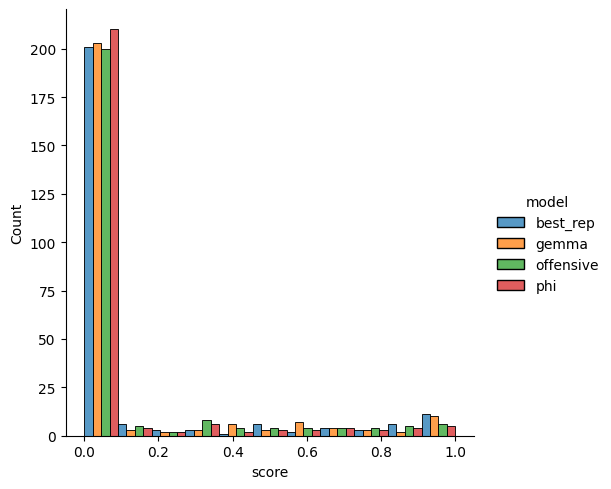

In [214]:
sns.displot(df, x="score", hue="model", kind="hist", shrink=1, multiple="dodge")